First, let's do some usual imports and define the environment

In [5]:
import torch
import gym

import numpy as np
import matplotlib.pyplot as plt

from gym import logger
logger.set_level(gym.logger.DISABLED)

In [6]:
NB_EPISODES = 10000
BATCH_SIZE = 8
LEARNING_RATE = 5e-4
GAMMA = 0.99
ENTROPY_COEF = 0.1
CRITIC_COEF = 0.5

In [7]:
cartpole = gym.make('CartPole-v0')

Then, we define our model :
  - two hidden layers of 8 neurons for the common network
  - two "heads" of 8 neurons for the Actor and the Critic
  
In addition to the forward method, we also define :
  - **evaluate_action** : that takes a pair (state, action) as input and outputs $V(s)$, $\log(\pi(a|s))$ and $H(s)$
      It will be used to update the actor according to $L_{actor} = \log(\pi(a | s)) * (R - V(s))$
  - **act** : that takes a state as input and sample an action according to the distribution given by the network

In [4]:
class Model(torch.nn.Module):
    def __init__(self, input_size, action_size):
        super(Model, self).__init__()
        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(4, 4),
            torch.nn.ReLU()
        )

        self.critic = torch.nn.Linear(4, 1)

        self.actor = torch.nn.Sequential(
            torch.nn.Linear(4, action_size),
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.hidden_layers(x)
        value = self.critic(x)
        actions = self.actor(x)
        return value, actions

    def get_critic(self, x):
        x = self.hidden_layers(x)
        return self.critic(x)

    def evaluate_action(self, state, action):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        log_probs = dist.log_prob(action).view(-1, 1)
        entropy = dist.entropy().mean()

        return value, log_probs, entropy

    def act(self, state):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        chosen_action = dist.sample()
        return chosen_action.item()

In [5]:
def train_one_sample(state, action, reward, next_state, done):
    action = torch.LongTensor([action])
    reward = torch.FloatTensor([reward])
   
    values, log_probs, entropy = model.evaluate_action(state.unsqueeze(0), action.unsqueeze(0))

    if done:
        next_value = reward
    else:
        next_value = reward + GAMMA * model.get_critic(next_state.unsqueeze(0))

    advantages = next_value - values
    critic_loss = advantages.pow(2).mean()

    actor_loss = -(log_probs * advantages.detach()).mean()
    total_loss = (CRITIC_COEF * critic_loss) + actor_loss - (ENTROPY_COEF * entropy)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    return values.mean().item()

<IPython.core.display.Javascript object>


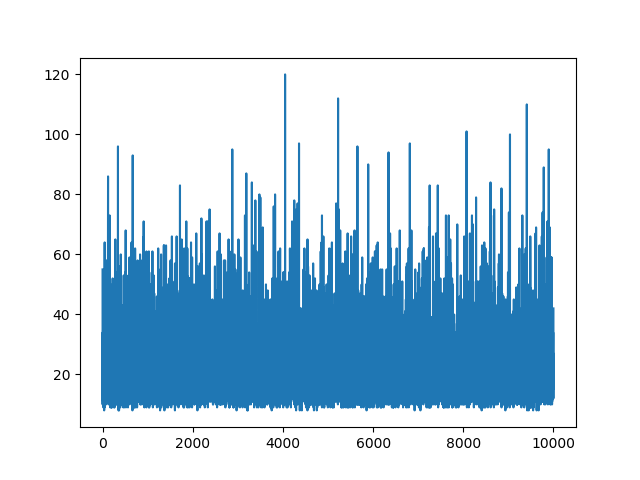

In [6]:
state_size = cartpole.observation_space.shape[0]
action_size = cartpole.action_space.n
model = Model(state_size, action_size)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, eps=1e-5)

state = torch.FloatTensor(cartpole.reset())

episode_rewards = []

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

for episode in range(NB_EPISODES):
    done = False
    episode_reward = 0
    
    state = torch.FloatTensor(cartpole.reset())
    
    while not done:
        action = model.act(state.unsqueeze(0))
        next_state, reward, done, _ = cartpole.step(action)
        next_state = torch.FloatTensor(state)
#         cartpole.render()

        # Train
        train_one_sample(state, action, reward, next_state, done)

        episode_reward += reward
        state = next_state

    episode_rewards.append(episode_reward)
    
    if len(episode_rewards) % 100 == 0:
        ax.clear()
        ax.plot(episode_rewards)
        fig.canvas.draw()

cartpole.close()

In [7]:
def compute_true_values(states, rewards, dones):
    values = []
    states = torch.stack(states)
    rewards = torch.FloatTensor(rewards)
    dones = torch.FloatTensor(dones)

    if dones[-1]:
        next_value = rewards[-1]
    else:
        next_value = model.get_critic(states[-1].unsqueeze(0))

    # Compute the sum of \gamma**t r_t
    values.append(next_value)
    for i in reversed(range(0, len(rewards) - 1)):
        if not dones[i]:
            next_value = rewards[i] + next_value * GAMMA
        else:
            next_value = rewards[i]
        values.append(next_value)

    values.reverse()

    return torch.FloatTensor(values)

In [8]:
def train(states, actions, true_values):
    states = torch.stack(states)
    actions = torch.LongTensor(actions)
    true_values = torch.FloatTensor(true_values)

    values, log_probs, entropy = model.evaluate_action(states, actions)

    advantages = true_values - values
    critic_loss = advantages.pow(2).mean()

    actor_loss = -(log_probs * advantages.detach()).mean()
    total_loss = (CRITIC_COEF * critic_loss) + actor_loss - (ENTROPY_COEF * entropy)

    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    return values.mean().item()

<IPython.core.display.Javascript object>


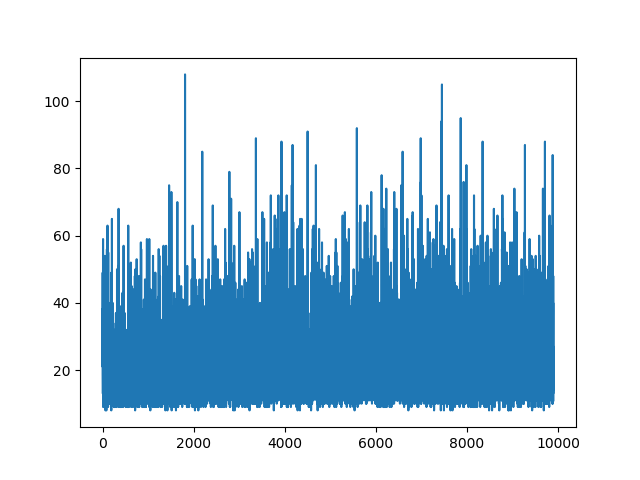

In [9]:
state_size = cartpole.observation_space.shape[0]
action_size = cartpole.action_space.n
model = Model(state_size, action_size)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, eps=1e-5)

state = torch.FloatTensor(cartpole.reset())

episode_rewards = []
episode_reward = 0

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

current_episode = 0
while current_episode < NB_EPISODES:

    done = False

    states = []
    actions = []
    rewards = []
    dones = []

    # Gather a batch of experience
    for _ in range(BATCH_SIZE):
        # Add a dimension to state because the model needs a batch (here, of size 1)
        action = model.act(state.unsqueeze(0))
        next_state, reward, done, _ = cartpole.step(action)
#         cartpole.render()

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)

        episode_reward += reward

        if done:
#             print("Episode ", current_episode, ", reward : ", episode_reward)
            state = torch.FloatTensor(cartpole.reset())
            
            if len(episode_rewards) % 100 == 0:
                ax.clear()
                ax.plot(episode_rewards)
                fig.canvas.draw()
            
            episode_rewards.append(episode_reward)
            episode_reward = 0
            current_episode += 1

        else:
            state = torch.FloatTensor(next_state)

    # Compute the true values for the update
    values = compute_true_values(states, rewards, dones)

    # Train
    train(states, actions, values)

cartpole.close()